In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random
import os

# 스케일 처리
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, Flatten, Dense, MaxPooling1D,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import to_categorical


In [2]:
'''
# global random seed를 설정
import tensorflow as tf
tf.random.set_seed(2)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
# Now build your graph and train it
'''

"\n# global random seed를 설정\nimport tensorflow as tf\ntf.random.set_seed(2)\nos.environ['TF_DETERMINISTIC_OPS'] = '1'\n# Now build your graph and train it\n"

In [3]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True
    
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(config.seed)

# 데이터 불러오기 및 전처리

In [4]:
# 스케일 변환
def X_scale(X):
    scaler = RobustScaler()
    X_scaled= scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled)
    return X_scaled

# 이상치 정리
def outlier(X):
    q1 = X.quantile(0.25)
    q3 = X.quantile(0.75)
    IQR = q3-q1
    condition = (X > (q1 - 1.5*IQR )) & (X < (q3 + 1.5*IQR ))
    X_drop = X[condition]
    X_fill = X_drop.fillna(X_drop.interpolate()) # Nan값을 앞뒤의 값의 동일 간격으로 채우기
    X_fill = X_fill.fillna(method='ffill')
    X_fill = X_fill.fillna(method='bfill')
    return X_fill

def X_array(X):
    N = X.shape[1]
    X_re = np.zeros((N, 40, 1))
    for k in range(N):
        X_re[k, :, 0]  = X.T.iloc[k,:]
    return X_re

def X_array_2D(X):
    N = X.shape[1]
    X_re = np.zeros((N, 5, 8))
    for k in range(N):
        for i in range(5):
            X_re[k, i,: ]  = X.T.iloc[k,i*5:i*5+8]
    return X_re


def Y_array(Y):
    N = Y.shape[1]
    Y_re = np.zeros((N,36))
    for k in range(N):
        Y_re[k, :] = Y.T.iloc[k,:]
    return Y_re

# y 스케일 변환
def Y_scale(Y): 
    scaler = StandardScaler()
    Y_scaled = scaler.fit_transform(Y)
    # Y_scaled = pd.DataFrame(Y_scaled)
    return scaler, Y_scaled


In [5]:
# 데이터 불러오기
B7_TM_re2 = pd.read_csv('../data/B7/B7_Al_TM_5x8.csv')
B7_MG = pd.read_csv('../data/B7/B7_Al_MG.csv')
V3_TM_re2 = pd.read_csv('../data/V3/V3_Al_TM_5x8.csv')
V3_MG = pd.read_csv('../data/V3/V3_Al_MG.csv')

# B7과 V3데이터 합치기
TM = pd.concat([B7_TM_re2 ,V3_TM_re2 ], axis=1)
MG = pd.concat([B7_MG ,V3_MG ], axis=1)

MG[MG == 755.0] = 75.5

print(TM.shape, B7_TM_re2.shape, V3_TM_re2.shape, MG.shape, B7_MG.shape, V3_MG.shape)

(40, 308) (40, 176) (40, 132) (36, 308) (36, 176) (36, 132)


In [6]:
# 스케일 처리 및 이상치 제거
X_scaled = X_scale(TM)
X_outliner = outlier(X_scaled)
X = X_array(X_outliner)
X_2D = X_array_2D(X_outliner)

Y_array = Y_array(MG)
scaler, Y = Y_scale(Y_array)

In [7]:
print('X의 shape: ', X.shape ,', Y의 shape:',Y.shape)

X의 shape:  (308, 40, 1) , Y의 shape: (308, 36)


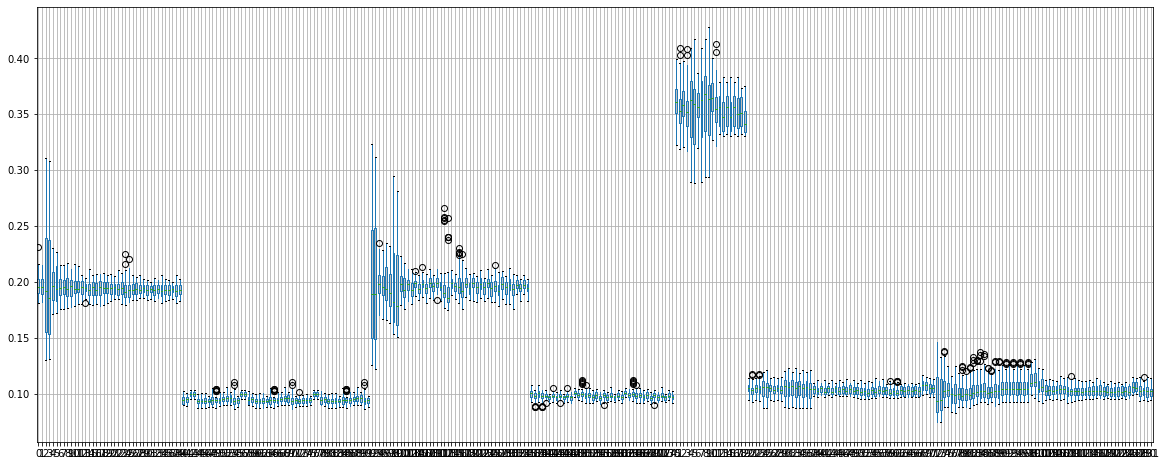

In [8]:
plt.figure(figsize=(20,8))
TM.boxplot()
plt.show()

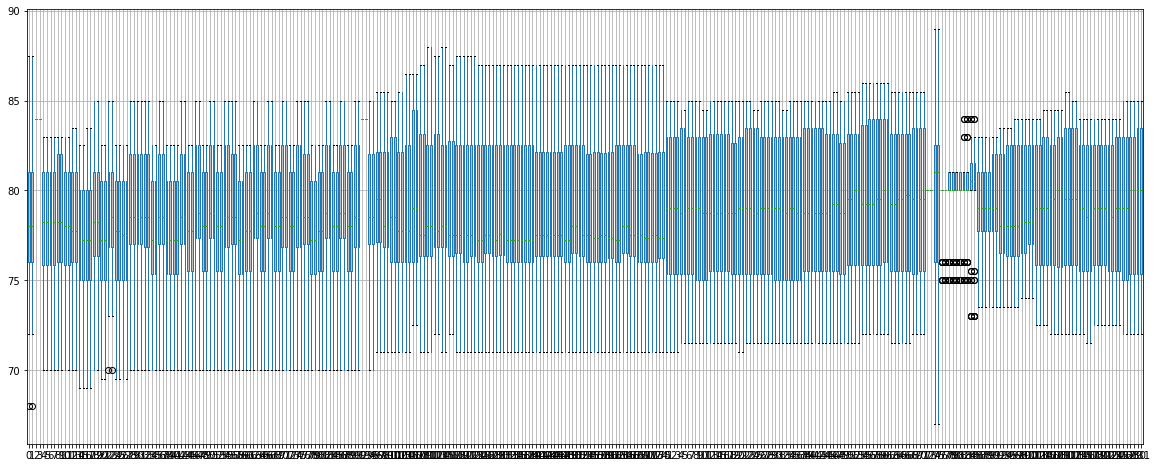

In [9]:
plt.figure(figsize=(20,8))
MG.boxplot()
plt.show()

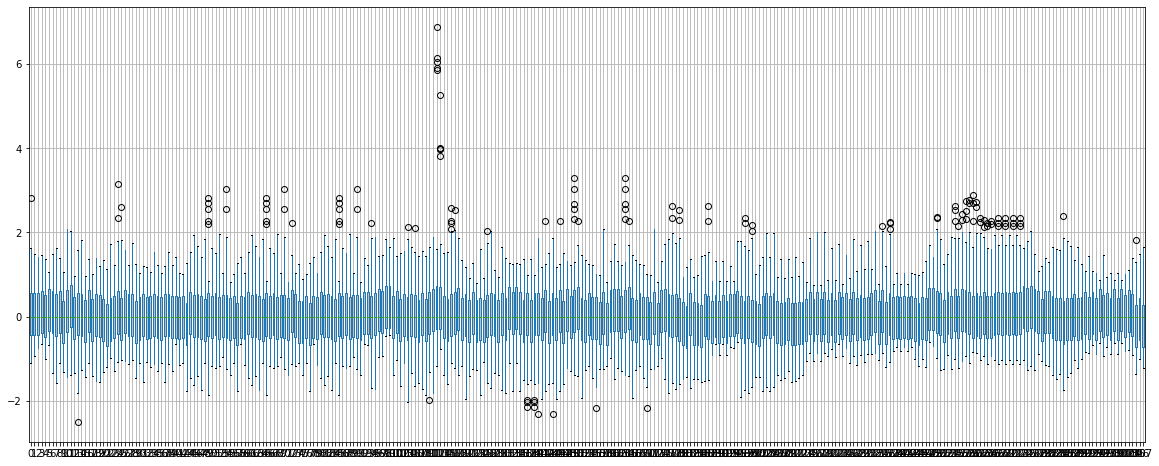

In [10]:
plt.figure(figsize=(20,8))
X_scaled.boxplot()
plt.show()

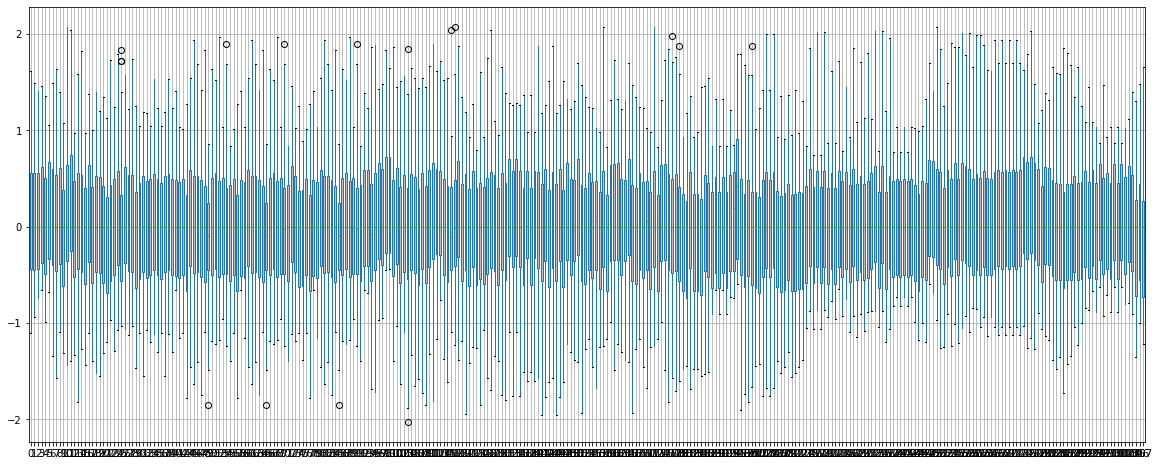

In [11]:
plt.figure(figsize=(20,8))
X_outliner.boxplot()
plt.show()

# 모델평가 함수 정의

In [12]:
def test_pred_plot(list,y_test, y_pred): 

    x_ax = range(36)

    plt.subplots(constrained_layout=True)
    for i,k in zip(range(1,5),list):
        plt.subplot(2,2,i)
        plt.plot(x_ax, y_test[k], label="test", color='y')
        plt.plot(x_ax, y_pred[k], label="pred", color='c')
        plt.legend()
        plt.title(k)
        plt.ylabel('MG Height')
        plt.xlabel('location')
    plt.show()

In [13]:
def test_pred_mean_plot(y_test, y_pred): 
    x_ax = range(36)
    plt.plot(x_ax, pd.DataFrame(y_test).mean(), label="test_mean", color='r')
    plt.plot(x_ax, pd.DataFrame(y_pred).mean(), label="pred_mean", color='b')
    #plt.ylim(-0.2,0.2)
    plt.legend()
    plt.ylabel('MG Height')
    plt.xlabel('location')
    plt.show()

In [14]:
def scaler_inv(y_test, y_pred):
    y_test_rev = scaler.inverse_transform(y_test)
    df_y_test = pd.DataFrame(y_test_rev.T)
    y_pred_rev = scaler.inverse_transform(y_pred)
    df_y_pred = pd.DataFrame(y_pred_rev.T)
    return y_test_rev, y_pred_rev, df_y_test, df_y_pred

# MLP

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (246, 40, 1) , X_test의 shape: (62, 40, 1) , y_train의 shape:  (246, 36) , y_test의 shape: (62, 36)
X_train의 shape:  (196, 40, 1) , X_test의 shape: (50, 40, 1) , y_train의 shape:  (196, 36) , y_test의 shape: (50, 36)


In [16]:
tf.keras.initializers.GlorotUniform(seed=1)
def model_MLP(X_train, y_train):
    
    model = Sequential()
    model.add(Flatten(input_shape=(40,1)))
    model.add(Dense(416, activation='relu')) 
    model.add(Dense(416, activation='relu'))
    model.add(Dense(480, activation='relu'))
    model.add(Dense(36 , activation=keras.layers.LeakyReLU(alpha=0.3)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=200, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [17]:
model, history = model_MLP(X_train, y_train)

Epoch 1/200
2/2 [==============================] - 2s 148ms/step - loss: 0.8896 - mae: 0.7252 - val_loss: 0.9048 - val_mae: 0.7411
Epoch 2/200
2/2 [==============================] - 0s 25ms/step - loss: 0.8396 - mae: 0.7018 - val_loss: 0.8659 - val_mae: 0.7272
Epoch 3/200
2/2 [==============================] - 0s 25ms/step - loss: 0.7896 - mae: 0.6781 - val_loss: 0.8143 - val_mae: 0.6976
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.7386 - mae: 0.6454 - val_loss: 0.7555 - val_mae: 0.6631
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.6781 - mae: 0.6091 - val_loss: 0.6953 - val_mae: 0.6344
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.6144 - mae: 0.5769 - val_loss: 0.6322 - val_mae: 0.6043
Epoch 7/200
2/2 [==============================] - 0s 25ms/step - loss: 0.5569 - mae: 0.5500 - val_loss: 0.5685 - val_mae: 0.5717
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 0.5055 - mae: 0.5

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 416)               17056     
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 dense_2 (Dense)             (None, 480)               200160    
                                                                 
 dense_3 (Dense)             (None, 36)                17316     
                                                                 
Total params: 408,004
Trainable params: 408,004
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Loss')

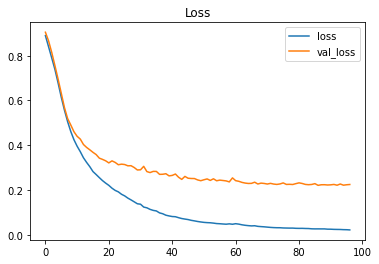

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')

## result

In [20]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 2ms/step
mae: 0.34272098706945237 mse: 0.39669267076161197 rmse: 0.6298354314911253 r2: 0.7042477754390536


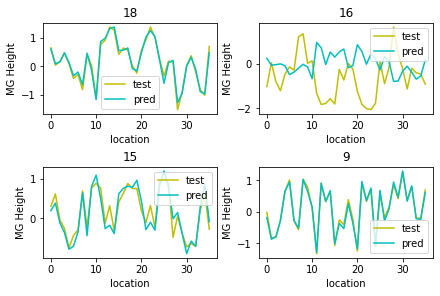

In [21]:
res = random.sample(range(1, y_test.shape[0]), 4)

test_pred_plot(res,y_test, y_pred)


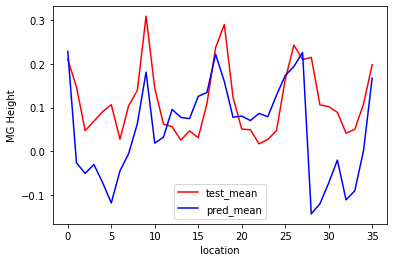

In [22]:
test_pred_mean_plot(y_test, y_pred)

In [23]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

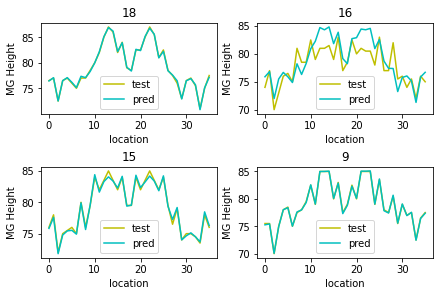

In [24]:
test_pred_plot(res, df_y_test, df_y_pred)

In [25]:
print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae: 0.5753953831170195 rmse: 1.0902659887654496 r2: 0.7042477259952789


In [26]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.007268674630928129 rmse: 0.013772770804265408 r2: 0.7042477259952789


# SVM

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (246, 40, 1) , X_test의 shape: (62, 40, 1) , y_train의 shape:  (246, 36) , y_test의 shape: (62, 36)
X_train의 shape:  (196, 40, 1) , X_test의 shape: (50, 40, 1) , y_train의 shape:  (196, 36) , y_test의 shape: (50, 36)


In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def model_SVM(X_train, y_train):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36

    model = Sequential()
    model.add(Reshape((40,), input_shape=(n_timesteps,n_features)))
    model.add(keras.Input(shape=(40,)))
    model.add(RandomFourierFeatures(output_dim=992, scale=7.0, kernel_initializer="Gaussian"))
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=200, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [29]:
model, history = model_SVM(X_train, y_train)

Epoch 1/200
2/2 [==============================] - 0s 131ms/step - loss: 1.6166 - mae: 1.0034 - val_loss: 1.1131 - val_mae: 0.8296
Epoch 2/200
2/2 [==============================] - 0s 30ms/step - loss: 1.0859 - mae: 0.8036 - val_loss: 1.1250 - val_mae: 0.8124
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: 1.0713 - mae: 0.7854 - val_loss: 1.0786 - val_mae: 0.7945
Epoch 4/200
2/2 [==============================] - 0s 36ms/step - loss: 0.9917 - mae: 0.7557 - val_loss: 0.9789 - val_mae: 0.7674
Epoch 5/200
2/2 [==============================] - 0s 34ms/step - loss: 0.8880 - mae: 0.7206 - val_loss: 0.9104 - val_mae: 0.7486
Epoch 6/200
2/2 [==============================] - 0s 26ms/step - loss: 0.8151 - mae: 0.6937 - val_loss: 0.8566 - val_mae: 0.7205
Epoch 7/200
2/2 [==============================] - 0s 38ms/step - loss: 0.7687 - mae: 0.6712 - val_loss: 0.8301 - val_mae: 0.7052
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.7442 - mae: 0.6

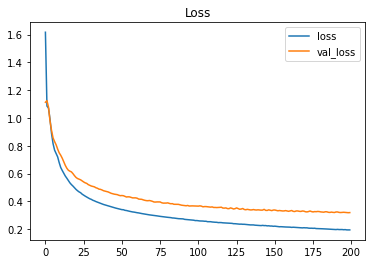

In [30]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [31]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),  'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 2ms/step
mae: 0.5022300604758508 mse: 0.6716411827824442 rmse: 0.819537175961191 r2: 0.5198362915457603


In [32]:
y_train

array([[ 0.30632954,  0.03936334, -0.23380336, ...,  0.00399217,
         0.61603787,  0.68878708],
       [ 0.63761289,  0.32802782,  0.14923619, ..., -0.81573317,
         0.34420454,  1.00924996],
       [ 0.30632954,  0.32802782, -0.42532313, ...,  0.00399217,
         0.61603787,  0.04786134],
       ...,
       [-0.02495381, -0.82663011, -0.80836268, ..., -0.20093916,
        -0.19946212,  0.68878708],
       [-0.35623716, -0.24930115, -0.23380336, ..., -0.20093916,
         0.34420454,  0.04786134],
       [-0.35623716, -1.1152946 , -0.80836268, ..., -0.4058705 ,
        -0.74312878, -0.59306441]])

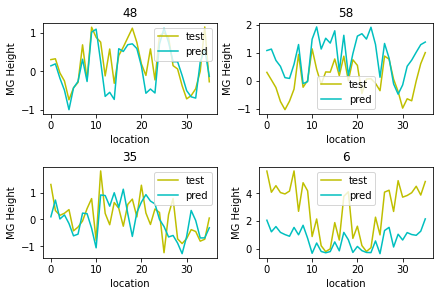

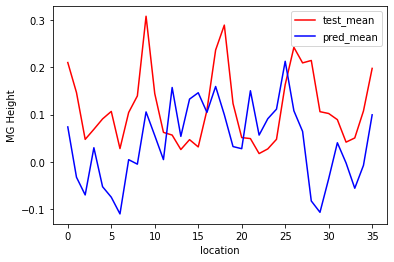

In [33]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

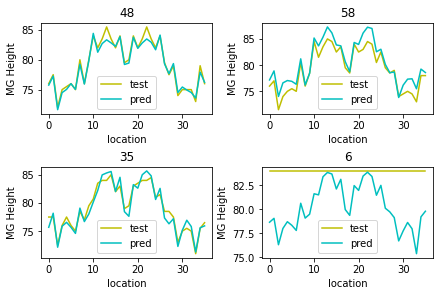

mae: 0.8440276921863625 rmse: 1.4116865878216522 r2: 0.5198363438382605


In [34]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

In [35]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.01066216875213986 rmse: 0.0178331123064189 r2: 0.5198363438382605


# 1D-CNN

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (246, 40, 1) , X_test의 shape: (62, 40, 1) , y_train의 shape:  (246, 36) , y_test의 shape: (62, 36)
X_train의 shape:  (196, 40, 1) , X_test의 shape: (50, 40, 1) , y_train의 shape:  (196, 36) , y_test의 shape: (50, 36)


In [37]:
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation

def model_1D_CNN(X_train, y_train,X_val, y_val):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36
    n_kernel_size = 3
    
    model = Sequential()
    model.add(Conv1D(filters=112, kernel_size= 3, input_shape=(n_timesteps,n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(filters=112, kernel_size= 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    '''
    model.add(Conv1D(filters=96, kernel_size= 4,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    '''
    #model.add(MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(Flatten())
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(80))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.55)))



    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [38]:
def model_1D_CNN(X_train, y_train,X_val, y_val):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36
    n_kernel_size = 3

    model = Sequential()
    model.add(Conv1D(filters=80, kernel_size= 5, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Flatten())
    model.add(Dense(112, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(96, activation='relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.5))) # , activation=None
    model.summary()


    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [39]:
model, history = model_1D_CNN(X_train, y_train,X_val, y_val)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 80)            480       
                                                                 
 flatten_1 (Flatten)         (None, 2880)              0         
                                                                 
 dense_5 (Dense)             (None, 112)               322672    
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense_6 (Dense)             (None, 96)                10848     
                                                                 
 dense_7 (Dense)             (None, 36)                3492      
                                                                 
Total params: 337,492
Trainable params: 337,492
Non-tr

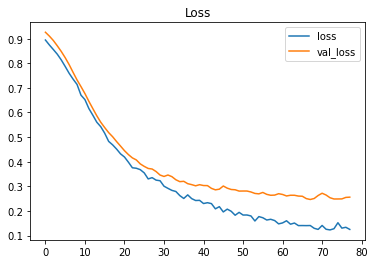

In [40]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [41]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 11ms/step
mae: 0.3805411809944685 mse: 0.43692705736967047 rmse: 0.6610045819581514 r2: 0.6743380677466357


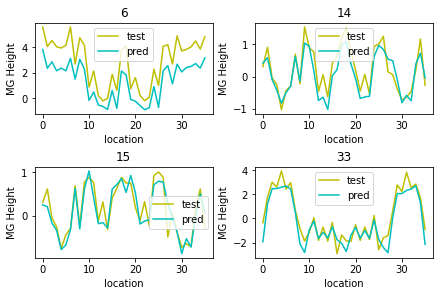

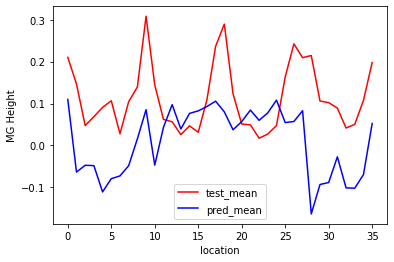

In [42]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

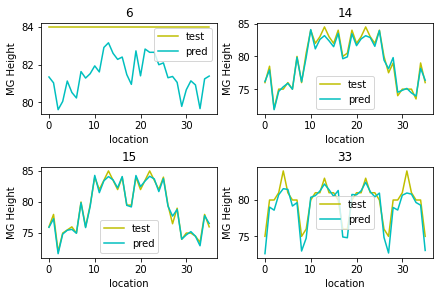

mae: 0.6349132900169673 rmse: 1.1241818257947582 r2: 0.6743380724396422


In [43]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

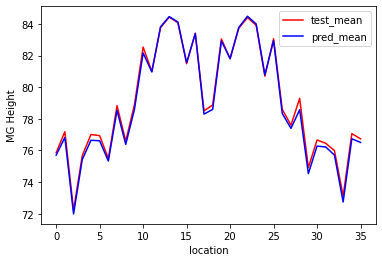

In [44]:
test_pred_mean_plot(df_y_test.T, df_y_pred.T)

In [45]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.008020533809265698 rmse: 0.014201212170732704 r2: 0.6743380724396422


# 2D-CNN

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (246, 5, 8) , X_test의 shape: (62, 5, 8) , y_train의 shape:  (246, 36) , y_test의 shape: (62, 36)
X_train의 shape:  (196, 5, 8) , X_test의 shape: (50, 5, 8) , y_train의 shape:  (196, 36) , y_test의 shape: (50, 36)


In [47]:
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation

def model_2D_CNN(X_train, y_train):
    input_shape = (5,8,1)
    n_outputs = 36
    
    model = Sequential()
    model.add(Conv2D(96, (3,3), input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (4,4) ,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(80, (4,4),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(Flatten())
    model.add(Dense(48))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(48))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.4)))


    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [48]:
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def model_2D_CNN(X_train, y_train):
    input_shape = (5,8,1)
    n_outputs = 36
    
    model = Sequential()
    model.add(Conv2D(48, (3,3), activation='relu', input_shape = input_shape))
    model.add(Flatten())
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(96, activation='relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.5)))



    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [49]:
model, history = model_2D_CNN(X_train, y_train)

Epoch 1/100
2/2 [==============================] - 1s 261ms/step - loss: 0.8939 - mae: 0.7265 - val_loss: 0.9324 - val_mae: 0.7517
Epoch 2/100
2/2 [==============================] - 0s 25ms/step - loss: 0.8850 - mae: 0.7226 - val_loss: 0.9278 - val_mae: 0.7501
Epoch 3/100
2/2 [==============================] - 0s 23ms/step - loss: 0.8783 - mae: 0.7193 - val_loss: 0.9229 - val_mae: 0.7477
Epoch 4/100
2/2 [==============================] - 0s 24ms/step - loss: 0.8709 - mae: 0.7155 - val_loss: 0.9168 - val_mae: 0.7446
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.8613 - mae: 0.7104 - val_loss: 0.9096 - val_mae: 0.7407
Epoch 6/100
2/2 [==============================] - 0s 24ms/step - loss: 0.8510 - mae: 0.7047 - val_loss: 0.9006 - val_mae: 0.7358
Epoch 7/100
2/2 [==============================] - 0s 25ms/step - loss: 0.8376 - mae: 0.6975 - val_loss: 0.8892 - val_mae: 0.7297
Epoch 8/100
2/2 [==============================] - 0s 25ms/step - loss: 0.8250 - mae: 0.6

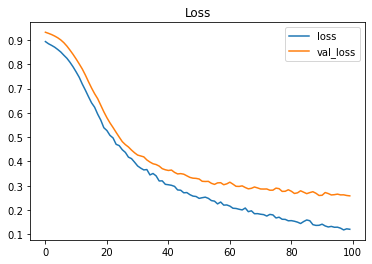

In [50]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [51]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 76ms/step
mae: 0.3995442468490327 mse: 0.4367354724042569 rmse: 0.6608596465243258 r2: 0.6655072700798794


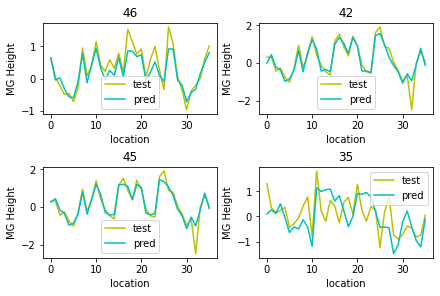

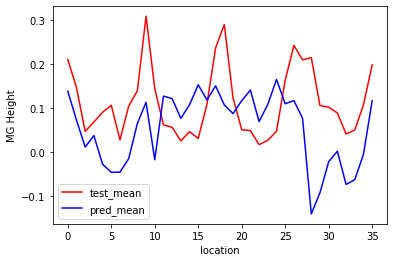

In [52]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

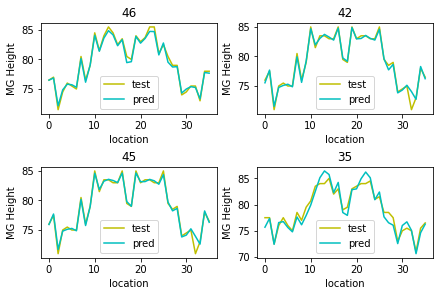

In [53]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

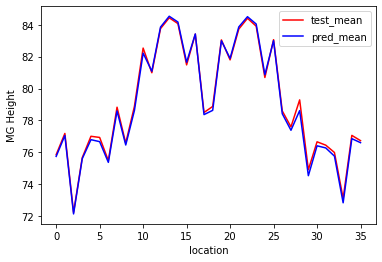

In [54]:
test_pred_mean_plot(df_y_test.T, df_y_pred.T)

In [55]:
print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae: 0.6673391595108962 rmse: 1.1173670740857558 r2: 0.6655072430422885


In [56]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.008430153180383199 rmse: 0.014115124909144046 r2: 0.6655072430422885


## 시각화

In [57]:
def Y_array_2D(X):
    N = X.shape[1]
    X_re = np.zeros((N, 4, 9))
    for k in range(N):
        for i in range(4):
            X_re[k, i,: ]  = X.T.iloc[k,i*4:i*4+9]
    return X_re

# Y_array()
test_ar = Y_array_2D(df_y_test)
pred_ar = Y_array_2D(df_y_pred)

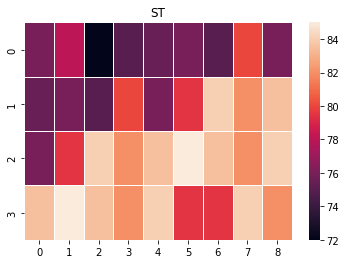

In [58]:
sns.heatmap(test_ar[0], linewidth=0.5)
plt.title('ST')
plt.show()

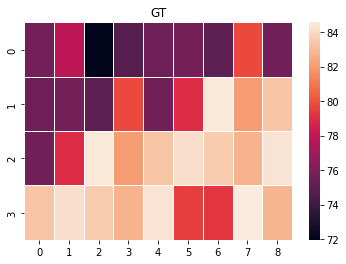

In [59]:
sns.heatmap(pred_ar[0], linewidth=0.5)
plt.title('GT')
plt.show()

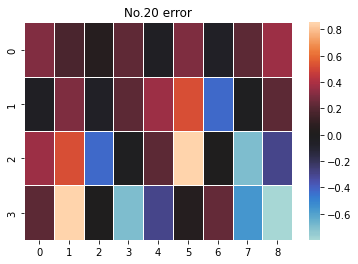

In [60]:
i = 0
sns.heatmap(test_ar[i] - pred_ar[i], linewidth=0.5, center=0)
plt.title('No.20 error')
plt.show()

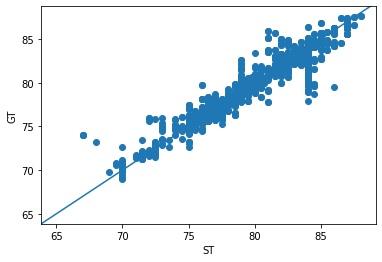

In [61]:
plt.scatter(test_ar,pred_ar)
plt.axline((65, 65), slope=1)
plt.ylabel('GT')
plt.xlabel('ST')
plt.show()

In [62]:
test_ar[0][0]

array([76. , 78. , 72. , 75. , 75.5, 76. , 75. , 80. , 76. ])

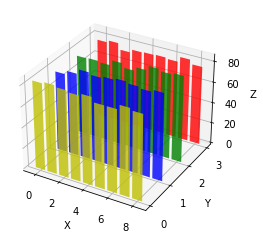

In [63]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]

for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = test_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

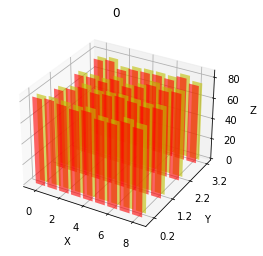

In [64]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'r', 'r', 'r']
yticks = [3, 2, 1, 0]
for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = test_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.6)

colors = ['y', 'y', 'y', 'y']
yticks = [3.2, 2.2, 1.2, 0.2]
for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = pred_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.6)
 
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)
plt.title('0')
plt.show()

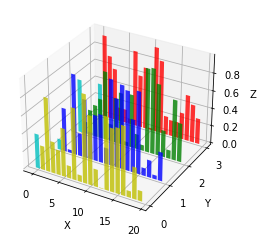

In [65]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]
for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

# ResNet

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (246, 5, 8) , X_test의 shape: (62, 5, 8) , y_train의 shape:  (246, 36) , y_test의 shape: (62, 36)
X_train의 shape:  (196, 5, 8) , X_test의 shape: (50, 5, 8) , y_train의 shape:  (196, 36) , y_test의 shape: (50, 36)


In [67]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    '''
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    '''
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [68]:
def ResNet50CL(input_shape = (5,8,1), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(36, activation = 'softmax')(X) # ouput layer (10 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50CL")
    
    return model

In [69]:
def ResNet50C(input_shape = (5,8,1), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
   
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    '''
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    '''
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(36, activation = keras.layers.LeakyReLU(alpha=0.4))(X) # ouput layer (10 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50C")
    
    return model

In [70]:
model = ResNet50C()
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "ResNet50C"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 8, 1)]    0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 8, 64)     640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 5, 8, 64)    256         ['conv2d_1[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 5, 8, 64)     0           ['batch_normalization[0][

In [71]:
EPOCH = 50
BATCH_SIZE = 4

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              patience=10, 
                             )

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
)


In [72]:
history = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val), 
                 epochs=EPOCH, 
                 batch_size=BATCH_SIZE, 
                 callbacks=[reduceLR, earlystopping],)

Epoch 1/50
49/49 [==============================] - 3s 26ms/step - loss: 1.1340 - mae: 0.7817 - val_loss: 1.2991 - val_mae: 0.9039 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 1s 18ms/step - loss: 0.8009 - mae: 0.6782 - val_loss: 1.1642 - val_mae: 0.8388 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 1s 18ms/step - loss: 0.6440 - mae: 0.5935 - val_loss: 1.0736 - val_mae: 0.8084 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - 1s 18ms/step - loss: 0.5875 - mae: 0.5663 - val_loss: 1.0022 - val_mae: 0.7578 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 1s 18ms/step - loss: 0.4379 - mae: 0.4771 - val_loss: 0.9394 - val_mae: 0.7434 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - 1s 18ms/step - loss: 0.4670 - mae: 0.4844 - val_loss: 0.7878 - val_mae: 0.6930 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - 1s 18ms/step - loss: 0.3934 - mae: 0.4478 - val_loss: 0.7604 - val_mae: 0.6424 - lr:

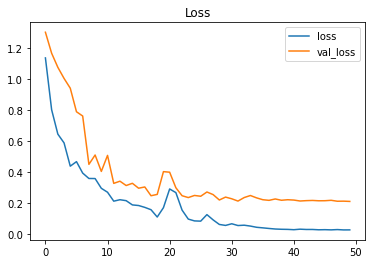

In [73]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

In [74]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 31ms/step
mae: 0.3346536551451728 mse: 0.44159821667814914 rmse: 0.6645285672400767 r2: 0.6707825925929969


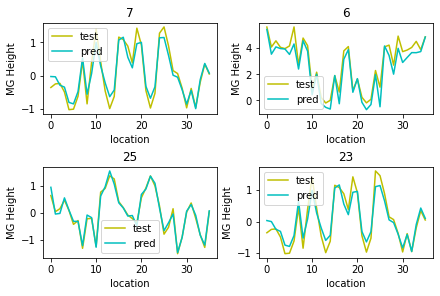

In [75]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)

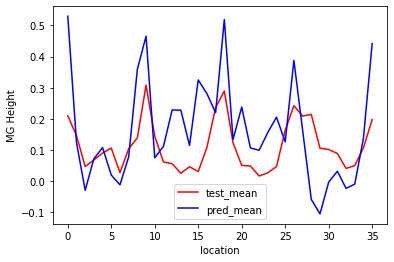

In [76]:
test_pred_mean_plot(y_test, y_pred)

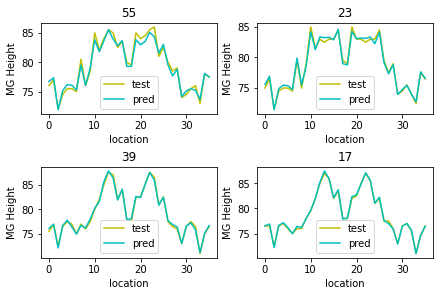

In [77]:
res = random.sample(range(1, y_test.shape[0]), 4)
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)